In [1]:
print("Checking and loading df2: ")

# https://stackoverflow.com/questions/40996175/loading-a-rds-file-in-pandas
#!pip install pyreadr
import pyreadr

# also works for RData
result = pyreadr.read_r('data/ams_anon_ext2.rds') 

# extract the pandas data frame 
df2 = result[None]

Checking and loading df2: 


C:\Users\15680\anaconda3\lib\site-packages\pandas\core\tools\datetimes.py:530: RuntimeWarning: invalid value encountered in multiply
  arr, tz_parsed = tslib.array_with_unit_to_datetime(arg, unit, errors=errors)


In [2]:
print("Set the printing option for pandas: \n")
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

print("See the head rows: \n")
df2.head()

Set the printing option for pandas: 

See the head rows: 



,hrd_prv_cd,hrd_ida,anm_ida,milkng_date,anb_cd,lact_no,lact_start_date,lact_end_date,dim,birth_date,stall_no,milkng_code,mk_wgt,milkng_start_date,box_time,lr_milk_time,lf_milk_time,rf_milk_time,rr_milk_time,milk_time,prep_time,milk_flow_avg,milk_flow_max,ft_pcnt,pt_pcnt,scc,milkng_temp
0,04,79b578b9,49cde907,2022-01-01 07:20:23,HO,5.0,2020-08-26,2022-03-13,493.0,2013-05-11,102.0,0.0,11.2,2022-01-01 07:09:50,10.550000,5.150000,7.966667,3.700000,2.683333,7.966667,2.583333,1.4,3.7,5.417476,3.461845,NaN,38.9
1,04,79b578b9,49cde907,2022-01-01 20:16:46,HO,5.0,2020-08-26,2022-03-13,493.0,2013-05-11,103.0,0.0,13.0,2022-01-01 20:08:59,7.783333,3.466667,5.000000,3.066667,3.350000,5.000000,2.783333,2.6,4.4,3.427184,3.393883,NaN,38.8
2,04,79b578b9,49cde907,2022-01-02 10:06:59,HO,5.0,2020-08-26,2022-03-13,494.0,2013-05-11,103.0,0.0,10.6,2022-01-02 09:58:31,8.466667,4.133333,5.450000,2.983333,3.066667,5.450000,3.016667,1.9,3.5,4.718447,3.384175,112.0,38.3
3,04,79b578b9,49cde907,2022-01-02 21:47:54,HO,5.0,2020-08-26,2022-03-13,494.0,2013-05-11,103.0,0.0,10.1,2022-01-02 21:38:17,9.616667,2.850000,5.166667,2.316667,3.033333,5.166667,4.450000,2.0,4.0,5.601942,3.481262,NaN,38.1
4,04,79b578b9,49cde907,2022-01-03 12:21:50,HO,5.0,2020-08-26,2022-03-13,495.0,2013-05-11,103.0,0.0,11.2,2022-01-03 12:14:17,7.550000,3.566667,4.833333,3.233333,4.600000,4.833333,2.716667,2.3,3.6,5.427184,3.384175,NaN,38.1


In [3]:
print("Load packages ...")
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# save in case of reloading
df = df2
df123 = df2
df456 = df2

Load packages ...


# Check herd and animal ID and change to numerical ID

In [4]:

""" 
method: 
    turning a column of hashing index into numerical index 
arg: 
    df: dataframe 
    column_name: string 
    rename: change to a new var_name or not (boolean)
return:
    df
"""
def numerical_id(df, column_name, rename=False):
    
    # list of anm_ida 
    idx_list = list(set(df[column_name].tolist()))

    # build a dictionary for mapping 
    idx_int = [i for i in range(len(idx_list))]
    dict_map = {idx_list[i]: idx_int[i] for i in range(len(idx_int))}

    if rename == False:
        df[column_name] = df[column_name].map(dict_map)
    else: 
        new_column_name = column_name + '_id'
        df[new_column_name] = df[column_name].map(dict_map)
    
    print(column_name, "Done")
    return df

In [5]:
print("columns and row: ", df.shape)
print("\nInspect the list of unique herd id: \n")
print(len(set(df['hrd_ida'].to_list())))
print("\nInspect the list of unique animal id: \n")
print(len(set(df['anm_ida'].to_list())))

print("\nReplace animal id and herd id from hashing code to numerical number: ")
# use function for anm_ida
df = numerical_id(df, 'anm_ida')
# use function for 
df = numerical_id(df, 'hrd_ida')

print("\nCheck if all herds are from Quebec, if so, delete column: hrd_prv_cd")
print(len(set(df['hrd_prv_cd'].to_list()))==1)
df = df.drop('hrd_prv_cd', axis=1)
print("\nShape after droped: ", df.shape)

columns and row:  (3210956, 27)

Inspect the list of unique herd id: 

51

Inspect the list of unique animal id: 

8014

Replace animal id and herd id from hashing code to numerical number: 
anm_ida Done
hrd_ida Done

Check if all herds are from Quebec, if so, delete column: hrd_prv_cd
True

Shape after droped:  (3210956, 26)


In [6]:
print("To give a list of percentage of SCC records for each farm: ")

""" 
method: 
    given a df, compute for each animal 
    the ratio of scc records vs. total records 
    return the average by herd 
arg: 
    df: complete df 
return: 
    ls_ratio_herd: list(float)
    ls_herd_id: list of id
"""
def herd_animal_scc_ratio(df):
    
    # a list of herd id
    ls_herd_id = list(set(df['hrd_ida'].tolist()))

    # init 
    ls_ratio_herd = []
    
    # looping all the herds 
    for herd_id in ls_herd_id: 
        
        # an example herd 
        one_herd = df.loc[df['hrd_ida']==herd_id]

        # a list of animal id
        list_animal = list(set(one_herd['anm_ida'].tolist()))

        # init 
        ls_ratio_animal = [] 
        
        # looping for all animals in this herd
        for idx in list_animal:
            # the number of records for this animal 
            num_records = one_herd.loc[one_herd['anm_ida']==idx].shape[0]
            # the number of nan for this animal 
            num_nan = one_herd.loc[one_herd['anm_ida']==idx]['scc'].isnull().sum()
            # the ratio of scc 
            ratio_scc = (num_records - num_nan) / num_records 
            # append to animal list 
            ls_ratio_animal.append(ratio_scc)
            
        # append to herd list 
        ls_ratio_herd.append(np.mean(ls_ratio_animal))
        
    return ls_herd_id, ls_ratio_herd

To give a list of percentage of SCC records for each farm: 


In [7]:
"""using function: herd_animal_scc_ratio"""
ls_herd_id, ls_ratio_herd = herd_animal_scc_ratio(df)

# Inspect the number of SCC-recorded animal and exclude non-recording farm: output(df_clean_scc)

In [8]:
print("The number of animals and the number of animal without scc in each herd: ")
print("for each herd, we inspect the number of animals and the status of their SCC records: ")

"""
method: 
    given all herds 
    return the number of animals and those without scc records 
arg: 
    df: complete dataframe with 'hrd_ida', 'anm_ida', and 'scc'
return: 
    ls_num_animal: list[int]
    ls_nan_animal: list[int]
"""
def herd_animal_scc(df):
    # a list of herd id
    ls_herd_id = list(set(df['hrd_ida'].tolist()))

    # init 
    ls_num_animal = []
    ls_nan_animal = []
    
    # looping all the herds 
    for herd_id in ls_herd_id: 
        # an example herd 
        one_herd = df.loc[df['hrd_ida']==herd_id]

        # a list of animal id
        list_animal = list(set(one_herd['anm_ida'].tolist()))

        # init num_nan_animal 
        num_nan_animal = 0
        # looping for all animals in this herd
        for idx in list_animal:
            # check if this animal has all nan in scc
            if_all_nan = one_herd.loc[one_herd['anm_ida']==idx]['scc'].isnull().all()
            # if all nan, add one to num_nan_animal 
            if if_all_nan: 
                num_nan_animal += 1
            # end second loop
        
        # appending 
        ls_num_animal.append(len(list_animal))
        ls_nan_animal.append(num_nan_animal)
        # end first loop 
        
    return ls_num_animal, ls_nan_animal
        

The number of animals and the number of animal without scc in each herd: 
for each herd, we inspect the number of animals and the status of their SCC records: 


In [9]:
""" 
args: 
    df: with hrd_ida 
    ls_num_animal: list[int]
    ls_nan_animal: list[int]
return: 
    a plot of herds with scc-recorded animal 
"""
def plot_herds_scc_nan(df, ls_num_animal, ls_nan_animal):
    # create data
    # herd id
    x = list(set(df['hrd_ida'].tolist()))
    # need y1 is ls_num_animal - ls_nan_animal (element-wise)
    y1 = [i1 - i2 for (i1, i2) in zip(ls_num_animal, ls_nan_animal)]
    # y2 is the ls_nan_animal
    y2 = ls_nan_animal

    # plot bars in stack manner
    plt.bar(x, y1, color='indigo', label='With SCC records')
    plt.bar(x, y2, bottom=y1, color='limegreen', label='Without SCC records')
    plt.xticks(x)
    plt.xticks(rotation=90)
    plt.legend(loc="upper left")
    plt.xlabel("herd id")
    plt.ylabel("number of cows")
    plt.show()

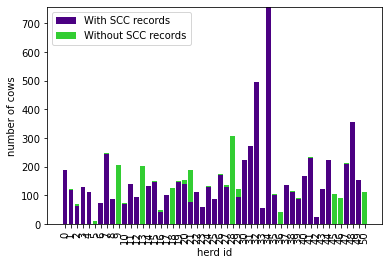

In [10]:
"""using function: herd_animal_scc"""
ls_num_animal, ls_nan_animal = herd_animal_scc(df)
"""using function: """
plot_herds_scc_nan(df, ls_num_animal, ls_nan_animal)

### Exlcude farms that without SCC records 

In [11]:
"""
args: 
    df: with hrd_ida 
    ls_num_animal: list[int]
    ls_nan_animal: list[int]
return: 
    df 
"""
def delete_non_scc_herds(df, ls_num_animal, ls_nan_animal):
    
    # herd id
    x = list(set(df['hrd_ida'].tolist()))
    
    # if ls_num_animal == ls_nan_animal, this herd has o scc record
    for i in range(len(x)): 
        if ls_num_animal[i] == ls_nan_animal[i]:
            # delete the herd from df 
            df = df.drop(df[df['hrd_ida'] == i].index, axis=0)
            
    return df

def delete_non_scc_animals(df):
    
    df = df[df['scc'].notna().groupby(df['anm_ida']).transform('any')]
    
    return df


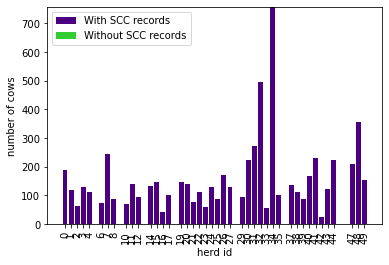

We have delete animals that have no SCC records


In [12]:
"""using function to delete herds"""
df = delete_non_scc_herds(df, ls_num_animal, ls_nan_animal)
"""using function to delete animals"""
df = delete_non_scc_animals(df)
# obtain the checking function again
ls_num_animal, ls_nan_animal = herd_animal_scc(df)
# to check if all the herds has scc
plot_herds_scc_nan(df, ls_num_animal, ls_nan_animal)
print("We have delete animals that have no SCC records")

In [13]:
# save df after cleaning nan scc 
df_clean_scc = df
print("We obtain the df with cleaned scc records (animal-wise): df_clean_scc")

We obtain the df with cleaned scc records (animal-wise): df_clean_scc


In [14]:
df_clean_scc.head()

,hrd_ida,anm_ida,milkng_date,anb_cd,lact_no,lact_start_date,lact_end_date,dim,birth_date,stall_no,milkng_code,mk_wgt,milkng_start_date,box_time,lr_milk_time,lf_milk_time,rf_milk_time,rr_milk_time,milk_time,prep_time,milk_flow_avg,milk_flow_max,ft_pcnt,pt_pcnt,scc,milkng_temp
0,7,5639,2022-01-01 07:20:23,HO,5.0,2020-08-26,2022-03-13,493.0,2013-05-11,102.0,0.0,11.2,2022-01-01 07:09:50,10.550000,5.150000,7.966667,3.700000,2.683333,7.966667,2.583333,1.4,3.7,5.417476,3.461845,NaN,38.9
1,7,5639,2022-01-01 20:16:46,HO,5.0,2020-08-26,2022-03-13,493.0,2013-05-11,103.0,0.0,13.0,2022-01-01 20:08:59,7.783333,3.466667,5.000000,3.066667,3.350000,5.000000,2.783333,2.6,4.4,3.427184,3.393883,NaN,38.8
2,7,5639,2022-01-02 10:06:59,HO,5.0,2020-08-26,2022-03-13,494.0,2013-05-11,103.0,0.0,10.6,2022-01-02 09:58:31,8.466667,4.133333,5.450000,2.983333,3.066667,5.450000,3.016667,1.9,3.5,4.718447,3.384175,112.0,38.3
3,7,5639,2022-01-02 21:47:54,HO,5.0,2020-08-26,2022-03-13,494.0,2013-05-11,103.0,0.0,10.1,2022-01-02 21:38:17,9.616667,2.850000,5.166667,2.316667,3.033333,5.166667,4.450000,2.0,4.0,5.601942,3.481262,NaN,38.1
4,7,5639,2022-01-03 12:21:50,HO,5.0,2020-08-26,2022-03-13,495.0,2013-05-11,103.0,0.0,11.2,2022-01-03 12:14:17,7.550000,3.566667,4.833333,3.233333,4.600000,4.833333,2.716667,2.3,3.6,5.427184,3.384175,NaN,38.1


# Checking abnormal vaule that equals zero: output df_clean_zero

In [15]:
"""
method: data_cleaning 

    clean and print the examples that were mis-recorded
args: 
    df: dataframe with columns: wk_wgt, milk_time...
return: 
    df: a cleaned dataframe 
"""
def data_cleaning(df):

    # initial samples
    samples = df.shape[0]
    print("number of samples before processing: \n", samples, "\n")
    
    df0 = df.loc[df['milkng_code'] == 0]
    print("discard examples by milkng_code=0: \n", df.shape[0] - df0.shape[0])

    df1 = df0.loc[df0['mk_wgt'] != 0]
    print("discard examples by mk_wgt=0: \n", df0.shape[0] - df1.shape[0])

    df2 = df1.loc[df1['milk_time'] != 0]
    print("discard examples by milk_time=0: \n", df1.shape[0] - df2.shape[0])

    df3 = df2.loc[df2['milk_flow_max'] != 0]
    print("discard examples by milk_flow_max=0: \n", df2.shape[0] - df3.shape[0])
    
    df4 = df3.loc[df3['milk_flow_avg'] != 0]
    print("discard examples by milk_flow_avg=0: \n", df3.shape[0] - df4.shape[0])

    df5 = df4.loc[(df4['lr_milk_time'] != 0) | (df4['lf_milk_time'] != 0) | (df4['rr_milk_time'] != 0) | (df4['rf_milk_time'] != 0)]
    print("discard examples by four milking time: \n", df4.shape[0] - df5.shape[0])
    
    print("\nnumber of samples after processing: \n", df5.shape[0], "\n")
    return df5

In [16]:
"""using function: data_"""
df_clean_zero = data_cleaning(df_clean_scc)
print("We obtain data with abnormal zeros cleaned: df_clean_zero")

number of samples before processing: 
 2653341 

discard examples by milkng_code=0: 
 51293
discard examples by mk_wgt=0: 
 630
discard examples by milk_time=0: 
 59
discard examples by milk_flow_max=0: 
 5
discard examples by milk_flow_avg=0: 
 33
discard examples by four milking time: 
 0

number of samples after processing: 
 2601321 

We obtain data with abnormal zeros cleaned: df_clean_zero


In [17]:
df_clean_zero.describe()

,hrd_ida,anm_ida,lact_no,dim,stall_no,milkng_code,mk_wgt,box_time,lr_milk_time,lf_milk_time,rf_milk_time,rr_milk_time,milk_time,prep_time,milk_flow_avg,milk_flow_max,ft_pcnt,pt_pcnt,scc,milkng_temp
count,2.601321e+06,2.601321e+06,2.601321e+06,2.601321e+06,2.601321e+06,2601321.0,2.601321e+06,2.601321e+06,2.601321e+06,2.601321e+06,2.601321e+06,2.601321e+06,2.601321e+06,2.601321e+06,2.601321e+06,2.601321e+06,2.601321e+06,2.601321e+06,942425.000000,2.601321e+06
mean,2.584874e+01,3.990216e+03,2.451419e+00,1.579822e+02,1.022217e+02,0.0,1.277352e+01,6.970670e+00,3.784095e+00,3.129945e+00,3.138477e+00,3.745242e+00,4.376627e+00,2.594044e+00,3.219002e+00,4.455466e+00,4.036831e+00,3.271076e+00,271.983768,3.870714e+01
std,1.565001e+01,2.306683e+03,1.501586e+00,1.178417e+02,1.850573e+00,0.0,3.922734e+00,2.069104e+00,1.820708e+00,1.545913e+00,1.536174e+00,1.819481e+00,1.907974e+00,7.826859e-01,1.110918e+00,1.395546e+00,9.964000e-01,4.208429e-01,533.679720,6.479622e-01
min,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.010000e+02,0.0,1.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.666667e-02,-8.433333e+00,1.000000e-01,2.000000e-01,0.000000e+00,0.000000e+00,1.000000,2.120000e+01
25%,1.100000e+01,1.965000e+03,1.000000e+00,6.800000e+01,1.010000e+02,0.0,1.010000e+01,5.550000e+00,2.583333e+00,2.133333e+00,2.133333e+00,2.550000e+00,3.050000e+00,2.200000e+00,2.400000e+00,3.500000e+00,3.504854e+00,3.141456e+00,39.000000,3.830000e+01
50%,3.000000e+01,3.985000e+03,2.000000e+00,1.410000e+02,1.020000e+02,0.0,1.220000e+01,6.550000e+00,3.450000e+00,2.850000e+00,2.850000e+00,3.416667e+00,3.966667e+00,2.433333e+00,3.100000e+00,4.300000e+00,4.038835e+00,3.296796e+00,75.000000,3.870000e+01
75%,4.000000e+01,5.995000e+03,3.000000e+00,2.260000e+02,1.030000e+02,0.0,1.480000e+01,7.916667e+00,4.633333e+00,3.833333e+00,3.850000e+00,4.583333e+00,5.250000e+00,2.800000e+00,3.900000e+00,5.300000e+00,4.592233e+00,3.442427e+00,198.000000,3.910000e+01
max,4.900000e+01,8.013000e+03,1.100000e+01,1.393000e+03,1.120000e+02,0.0,5.440000e+01,1.184000e+02,2.140000e+01,2.093333e+01,2.081667e+01,2.096667e+01,2.140000e+01,1.159333e+02,2.100000e+01,1.270000e+01,1.406796e+01,6.500680e+00,10552.000000,5.370000e+01


# Plot some SCC records status for some cows and herds

In [18]:
""" 
method: 
    to visualize scc for a cow or an herd  
arg: 
    df: dataframe with 'hrd_ida', 'anm_ida', 'scc' 
    herd_idx: choose a herd to plot (in [0, len(herds)])
    anm_idx: choose an animal to plot (in [0, len(animals)])
    if_animal: default is False, plot the animal if this is set to True
return: 
    a plot of scc for an animal and an herd
"""
def visualize_scc(df, herd_idx, anm_idx, if_animal=False):
    
    if if_animal == True: 
        
        # animal id 
        anm_id_ls = list(set(df['anm_ida'].tolist()))
        
        # plot animal
        df = df.loc[df['anm_ida'] == anm_id_ls[anm_idx]]
        plt.plot(df['scc'])
        plt.show()
        
    else:
        
        # herd id
        x = list(set(df['hrd_ida'].tolist()))
    
        # plot herd 
        df = df.loc[df['hrd_ida'] == x[herd_idx]]
        plt.plot(df['scc'])
        plt.show() 

# Imputation for other missing values (ft_pcnt, pt_pcnt, scc, milkng_temp): input(df_clean_zero), output(df_inputated)

In [19]:
""" 
func: 
    get the cutting index from a list by a threshold 
args: 
    scc_ls: list[int]
    missing_threshold: int 
return: 
    cuts_ls: list[int]
"""
def get_cutting_index(scc_ls, missing_threshold):
    # init count for continous nan
    count_nan = 0
    # init missing_threshold
    missing_threshold = 5
    # use a list to store the cuts (index that was cut by discontinuity)
    cuts_ls = [0]

    # loop scc_ls
    for i in range(len(scc_ls)):
        # compare nan with any number output False
        if not (scc_ls[i] > -1): 

            # increase count 
            count_nan += 1 

            # if count_nan excess a threshold
            # output the index (the range of this threshold)
            if count_nan >= missing_threshold: 
                cuts_ls.append(i-missing_threshold)
                cuts_ls.append(i)

        # if meet not-nan 
        else: 
            # reset not-nan 
            count_nan = 0

    # the last index is the length 
    cuts_ls.append(len(scc_ls))

    return cuts_ls

In [20]:
""" 
func: 
    insert period index, for each animal 
    if the milking period is not cut for a min_len
    a period index is assigned with (anm_id*10) + int(0, 1, 2, 3)
args: 
    df_one_anm: dataframe with ['anm_ida']
    cuts_ls: list[int]
    min_len_milking: the min length of milkings records [int]
return: 
    df_one_anm: dataframe with added ['period_index']
"""
def insert_period_index(df_one_anm, cuts_ls, min_len_milking=50):
    # init the column named period_index 
    # get shape, 0 is the index
    df_one_anm.insert(0, "period_index", [-1 for i in range(df_one_anm.shape[0])])
    # get animal id: from the first row 
    anm_id = df_one_anm["anm_ida"].iloc[0]
    # init period index (raw index inside each animal)
    period_raw = 1

    # loop by cuts_ls
    for i in range(len(cuts_ls)-1): 
        # if length is longer than minimum length
        if cuts_ls[i+1] - cuts_ls[i] > min_len_milking: 
            # increse raw period index 
            period_raw += 1
            # insert the period index, the period index is at column index 0
            # period index combined with animal index 
            period_index = (anm_id*10) + period_raw
            # set the period index in the dataframe
            ls = [period_index for i in range(cuts_ls[i+1]-cuts_ls[i])]
            df_one_anm.iloc[cuts_ls[i]:cuts_ls[i+1], 0] = ls

    return df_one_anm

In [21]:
""" 
func: 
    use insert_period_index for each animal
args: 
    df: dataframe with ["anm_ida"], ["scc"]
    missing_threshold: int
    min_len_milking: int
return: 
    df_period_index: dataframe with ["period_index"]
"""
def insert_period_index_loop_animal(df, missing_threshold, min_len_milking):
    
    # get a list of all animals index
    animals_index_ls = df["anm_ida"].unique().tolist()
    print("Number of animals: ", len(animals_index_ls))
    
    # init a list to store all temporial df 
    temp_df_ls = [] 
    
    # looping by animal index 
    for idx in animals_index_ls: 
        
        # get the data from one animal 
        df_one_anm = df[df["anm_ida"] == idx]

        # get the scc list 
        scc_ls = df_one_anm["scc"].tolist()

        """using func: """
        cuts_ls = get_cutting_index(scc_ls, missing_threshold)

        """using func: """
        df_one_anm_returned = insert_period_index(df_one_anm, cuts_ls, min_len_milking)

        # append 
        temp_df_ls.append(df_one_anm_returned)
    
    # concat temp_df_ls
    df_concat = pd.concat(temp_df_ls)
    
    return df_concat

In [22]:
# supress warning
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

df_period_index = insert_period_index_loop_animal(df_clean_zero, missing_threshold=30, min_len_milking=60)

Number of animals:  6614


### Imputation

In [23]:
# ingore future warning
import warnings
warnings.filterwarnings("ignore", message=r"Passing", category=FutureWarning)
# surprass chain warning
pd.set_option('mode.chained_assignment', None)
#warnings.filterwarnings("ignore", message=r"Passing", category=SettingWithCopyWarning)

In [24]:
# imputation 
# https://stackoverflow.com/questions/54489299/how-to-fill-missing-values-using-values-of-closest-neighboring-years-for-a-panda
# https://stackoverflow.com/questions/33261359/pandas-replace-zeros-with-previous-non-zero-value
# https://stackoverflow.com/questions/18265930/pandas-filling-missing-values-within-a-group

"""
args: 
    df_clean_zero: with scc, anm_ida, ft_pcnt, pt_pcnt, milkng_temp
    var_list_nan: list[str] the list that needs to fill nan 
    var_list_zero: list[str] the list that needs to fill zero
return: 
    df_clean_zero
"""
def imputation_neighbor_nan(df_test, var_name_nan):
    
    for var_name in var_name_nan:
        print("Number of nan before: ", var_name, df_test[var_name].isna().sum())
        # the default is forward
        df_test.loc[:, var_name] = df_test.groupby('anm_ida')[var_name].ffill()
        print("Number of nan after: ", var_name, df_test[var_name].isna().sum())
    
    return df_test

def imputation_neighbor_zero(df_temp, var_list_zero):
    
    # loop through the list to fill zero 
    for var_str in var_list_zero:
        print("Number of zero before in ", var_str, ": ", df_temp[var_str].isin([0]).sum())
        df_temp.loc[:, var_str] = df_temp.groupby('anm_ida')[var_str].ffill()
        df_temp.loc[:, var_str] = df_temp.groupby('anm_ida')[var_str].bfill()
        print("Number of zero after: ", var_str, ": ", df_temp[var_str].isin([0]).sum())
    
    return df_temp

In [25]:

print("Using function to inputate nan: ")
var_list_nan = ['scc', 'milkng_temp']
df_inputated = imputation_neighbor_nan(df_period_index, var_list_nan)
print("Done")

print()
print("Using function to imputate zero: ")
var_list_zero = ['ft_pcnt', 'pt_pcnt', 'milkng_temp']
df_inputated = imputation_neighbor_zero(df_inputated, var_list_zero)
print("Done")

print()
print("Check scc nan: ", df_inputated['scc'].isna().sum())
print("Delete nan in SCC")
df_inputated = df_inputated[df_inputated['scc'].notna()]
print("Check scc nan again: ", df_inputated['scc'].isna().sum())

print("For those ft_pcnt and pt_pcnt that is still zero, replace with median")
df_inputated.loc[:, 'ft_pcnt']= df_inputated.loc[:, 'ft_pcnt'].replace(0, df_inputated.loc[:, 'ft_pcnt'].median())
df_inputated.loc[:, 'pt_pcnt']= df_inputated.loc[:, 'pt_pcnt'].replace(0, df_inputated.loc[:, 'pt_pcnt'].median())
print("Done")

Using function to inputate nan: 
Number of nan before:  scc 1658896
Number of nan after:  scc 34400
Number of nan before:  milkng_temp 0
Number of nan after:  milkng_temp 0
Done

Using function to imputate zero: 
Number of zero before in  ft_pcnt :  27423
Number of zero after:  ft_pcnt :  27423
Number of zero before in  pt_pcnt :  27176
Number of zero after:  pt_pcnt :  27176
Number of zero before in  milkng_temp :  0
Number of zero after:  milkng_temp :  0
Done

Check scc nan:  34400
Delete nan in SCC
Check scc nan again:  0
For those ft_pcnt and pt_pcnt that is still zero, replace with median
Done


# Convert visiting-based records to daily-based records 
# input(df_inputated), output(df_by_day)

In [26]:
#df_inputated.iloc[:500, :]

In [27]:
""" 
method: 
    to add previous scc_history as a vairable
arg: 
    temp_df with columns: anm_ida and scc
return: 
    temp_df with columns: scc_history
"""
def add_scc_history(temp_df):

    # init list for scc_history
    scc_history = [0 for i in range(len(temp_df))] 
    has_scc = 0
    
    # build two lists: cow_id_ls with cow id and scc_ls with scc
    cow_id_ls = temp_df['anm_ida'].to_list()
    scc_ls = temp_df['scc'].to_list()
    
    # looping cow_id_ls
    for i in range(len(cow_id_ls)-1):
        
        # get temp scc
        temp_scc = scc_ls[i]
        # change has if meet high value
        if temp_scc > 2000: 
            has_scc = 1
        elif temp_scc > 3000:
            has_scc = 2
            
        # append to the scc_history 
        scc_history[i] = has_scc
        # if cow id change, reset has_scc 
        this_id = cow_id_ls[i]
        next_id = cow_id_ls[i+1]
        if next_id != i: 
            has_scc = 0

    # finish looping
    # handle the last element 
    scc_history[-1] = scc_history[-2]
    temp_df['scc_history'] = scc_history
    
    return temp_df

In [28]:
# ratio of fat/protein 
# ratio of max/min flow rate

# Environment: weather (cold or hot 0/1) 
# Cow info: 
    # DIM (3 stages), 
    # parity (0 or 2 or more), 
    # prior mastitis cases (have or not)
    
"""
method: 
    to create new variables 

arg: 
    df with columns: 
    ft_pcnt
    pt_pcnt
    milk_flow_max
    flow_min
"""
def add_cow_info(temp_df):

    # Cow info: 
    
    # DIM (3 stages), 
    temp_df.loc[temp_df['dim'] <= 100, 'lact_stage'] = 1
    temp_df.loc[temp_df['dim'] > 100, 'lact_stage'] = 2
    temp_df.loc[temp_df['dim'] > 200, 'lact_stage'] = 3
    
    # parity (0 or 2 or more), 
    temp_df.loc[temp_df['lact_no'] <= 2, 'parity'] = 1  
    temp_df.loc[temp_df['lact_no'] > 2, 'parity'] = 2  
    temp_df.loc[temp_df['lact_no'] > 5, 'parity'] = 3
    
    # scc_history
    """ ---------- calling add_scc_history ----------- """
    temp_df = add_scc_history(temp_df)
    print("columns that have null: ", temp_df.columns[temp_df.isnull().any()].tolist())
    temp_df['cow_info'] = temp_df['lact_stage'] + temp_df['parity'] + temp_df['scc_history']

    return temp_df

In [29]:
""" 
method: 
    to count the length of each sequence 
    use a for loop to count 
arg: 
    ls: list() with length > 2 (this will the list of 'anm_ida_milkng_date')
return: 
    result: list(int)
"""
def count_sequence_len(ls):
    
    # init result 
    result = [] 
    # init count_seq 
    count_seq = 0
    
    # looping the list (excluding the last element)
    for i in range(len(ls)-1): 
        count_seq += 1
        # when meets the another sequence
        if (ls[i+1] != ls[i]) or (i+2 == len(ls)): 
            # append to result
            result.append(count_seq) 
            # reset count_seq 
            count_seq = 0 
    
    # handle the last element 
    # if the last element is equal the one before
    if ls[-1] == ls[-2]: 
        # add one for the last element in result
        result[-1] += 1
    # else add one element to result
    else: 
        result = result + [1]
        
    return result


In [30]:
print("Adding cow_info and obtaining no_visit")
df_add_cow_info = add_cow_info(df_inputated)

Adding cow_info and obtaining no_visit
columns that have null:  ['lact_end_date']


In [31]:
print("As the variable milkng_date now have the time, we need to use milkng_date_time to represent date with time and milkng_date with only date: ")
import datetime as dt

# get the date in string
date_str = df_add_cow_info["milkng_date"].dt.strftime('%Y-%m-%d').tolist()
# set date time
df_add_cow_info["milkng_date_time"] = df_add_cow_info["milkng_date"]
# convert date string to date int 
date_int = [int(i[:4])*10000 + int(i[5:7])*100 + int(i[8:]) for i in date_str]
# set date only
df_add_cow_info["milkng_date"] = date_int
print("Done")

As the variable milkng_date now have the time, we need to use milkng_date_time to represent date with time and milkng_date with only date: 
Done


In [32]:
df_add_cow_info.head()

,period_index,hrd_ida,anm_ida,milkng_date,anb_cd,lact_no,lact_start_date,lact_end_date,dim,birth_date,stall_no,milkng_code,mk_wgt,milkng_start_date,box_time,lr_milk_time,lf_milk_time,rf_milk_time,rr_milk_time,milk_time,prep_time,milk_flow_avg,milk_flow_max,ft_pcnt,pt_pcnt,scc,milkng_temp,lact_stage,parity,scc_history,cow_info,milkng_date_time
2,56392,7,5639,20220102,HO,5.0,2020-08-26,2022-03-13,494.0,2013-05-11,103.0,0.0,10.6,2022-01-02 09:58:31,8.466667,4.133333,5.450000,2.983333,3.066667,5.450000,3.016667,1.9,3.5,4.718447,3.384175,112.0,38.3,3.0,2.0,0,5.0,2022-01-02 10:06:59
3,56392,7,5639,20220102,HO,5.0,2020-08-26,2022-03-13,494.0,2013-05-11,103.0,0.0,10.1,2022-01-02 21:38:17,9.616667,2.850000,5.166667,2.316667,3.033333,5.166667,4.450000,2.0,4.0,5.601942,3.481262,112.0,38.1,3.0,2.0,0,5.0,2022-01-02 21:47:54
4,56392,7,5639,20220103,HO,5.0,2020-08-26,2022-03-13,495.0,2013-05-11,103.0,0.0,11.2,2022-01-03 12:14:17,7.550000,3.566667,4.833333,3.233333,4.600000,4.833333,2.716667,2.3,3.6,5.427184,3.384175,112.0,38.1,3.0,2.0,0,5.0,2022-01-03 12:21:50
5,56392,7,5639,20220103,HO,5.0,2020-08-26,2022-03-13,495.0,2013-05-11,103.0,0.0,6.1,2022-01-03 20:24:25,8.683333,2.966667,5.116667,2.450000,2.166667,5.116667,3.566667,1.2,2.7,4.796117,3.393883,104.0,38.0,3.0,2.0,0,5.0,2022-01-03 20:33:06
6,56392,7,5639,20220104,HO,5.0,2020-08-26,2022-03-13,496.0,2013-05-11,103.0,0.0,11.3,2022-01-04 11:54:19,9.050000,3.433333,5.550000,2.633333,2.666667,5.550000,3.500000,2.0,4.0,4.699029,3.316214,104.0,38.4,3.0,2.0,0,5.0,2022-01-04 12:03:22


In [33]:
""" 
method: 
    1. first build min_milk_time, and var_milk_time 
    2. the groupby each variable: 
        adding: wk_wgt, 
        min: min_time
        max: var_time, milk_flow_max, scc
        ave: ft_pcnt, pt_pcnt, milkng_temp, dim, lact_no
     3. no_visit: using anm_ida + milkng_date
     4. cow_info: use anm_ida + milng_date + parity + dim + scc
     
arg: 
    df: dataframe with ... 
    
return:

"""
def grouping(df): 
    
    # build min_time: min(lf, lr, rf, rr milk time) 
    min_time = df.loc[:,['lr_milk_time', 'lf_milk_time', 'rf_milk_time', 'rr_milk_time']].min(axis=1)
    # add into the column
    df['min_time'] = min_time

    # get vars by rows from four selected columns
    var_time = df.loc[:,['lr_milk_time', 'lf_milk_time', 'rf_milk_time', 'rr_milk_time']].var(axis=1)
    # append to the df dataset 
    df['var_time'] = var_time

    # create a new variable that is unique for each cow and each day: anm_ida + milkng_date
    df['anm_ida_milkng_date'] = df['anm_ida'].apply(lambda x: str(x) + "-") + df['milkng_date'].apply(lambda x: str(x))
    
    # we need a list of idx for 'anm_ida_milkng_date', to keep in the final df 
    #"""using function: numerical_id"""
    #df = numerical_id(df, 'anm_ida_milkng_date', rename=True)
    
    """using function: count_sequence_len"""
    no_visit = count_sequence_len(df['anm_ida_milkng_date'].tolist())

    # grouping with aggregate function 
    # https://stackoverflow.com/questions/33217702/groupby-in-pandas-with-different-functions-for-different-columns
    df_group = df.groupby(['anm_ida_milkng_date']).aggregate({'mk_wgt':np.sum, 
                                                              'min_time': 'min', 
                                                              'var_time': 'max',
                                                              'milk_flow_max':'max',
                                                              'scc':'max', 
                                                              'ft_pcnt':'mean', 
                                                              'pt_pcnt':'mean', 
                                                              'milkng_temp':'mean', 
                                                              'cow_info':'max', 
                                                              # add the new idx
                                                              'anm_ida':'max',
                                                              'hrd_ida':'max',
                                                              'prep_time':'mean',
                                                              'milkng_date':'max',
                                                              'dim':'max',
                                                              'period_index':'max'
                                                             })
    # append no_visit 
    df_group["no_visit"] = no_visit
    
    return df_group

In [34]:
"""using func: """
print("Grouping ...")
df_final = grouping(df_add_cow_info)
print("Done!")

Grouping ...
Done!


In [35]:
check_scc_nan = df_final[df_final["period_index"] == -1]["period_index"].tolist()
print("Number of consequtive scc nan records: ", len(check_scc_nan))
print(df_final.shape)

Number of consequtive scc nan records:  235617
(907485, 16)


# After Data Pre-processing, We Obtain df_final

In [36]:
df_final.head()

,mk_wgt,min_time,var_time,milk_flow_max,scc,ft_pcnt,pt_pcnt,milkng_temp,cow_info,anm_ida,hrd_ida,prep_time,milkng_date,dim,period_index,no_visit
anm_ida_milkng_date,,,,,,,,,,,,,,,,
1-20221202,26.6,2.100000,0.536852,3.5,5.0,5.126214,4.028188,38.000000,2.0,1,29,3.294444,20221202,4.0,-1,2
1-20221203,31.7,2.383333,0.927477,3.5,5.0,5.271845,3.999061,38.133333,2.0,1,29,2.961111,20221203,5.0,-1,2
1-20221204,26.8,2.283333,0.430995,3.5,1.0,5.168285,3.911683,38.100000,2.0,1,29,3.805556,20221204,6.0,-1,2
1-20221205,35.2,2.700000,0.484884,4.0,1.0,4.912621,3.863139,38.333333,2.0,1,29,4.350000,20221205,7.0,-1,2
1-20221206,41.7,2.066667,0.504630,3.7,1.0,4.898058,3.842913,38.425000,2.0,1,29,3.141667,20221206,8.0,-1,2


In [37]:
print("Basic setting: ")

print("change name to df")
df = df_final 

print("Deleting the discontious SCC where period_index==-1")
print("Shape: ", df.shape)
df = df[df["period_index"] != -1]
print("Shape: ", df.shape)

print("Shift scc to the first column for simplicity")
# shift column 'scc' to first position
first_column = df.pop('scc')
# insert column using insert(position,column_name, first_column) function
df.insert(0, 'scc', first_column)

print("For convinent, make milkng_date the string")
milkng_date_only = df['milkng_date'].apply(lambda x: str(x))
df['milkng_date_only'] = milkng_date_only

Basic setting: 
change name to df
Deleting the discontious SCC where period_index==-1
Shape:  (907485, 16)
Shape:  (671868, 16)
Shift scc to the first column for simplicity
For convinent, make milkng_date the string


In [38]:
print("Ignore chaining warning... ")
# ingore future warning
import warnings
warnings.filterwarnings("ignore", message=r"Passing", category=FutureWarning)
# surprass chain warning
pd.set_option('mode.chained_assignment', None)
#warnings.filterwarnings("ignore", message=r"Passing", category=SettingWithCopyWarning)

Ignore chaining warning... 


In [39]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd

print("testing the ADF test")
target = pd.Series([1, 2, 3, 4, 5, 6, 7, 8])
ad_fuller_result = adfuller(target)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')
print("note that the larger p-value suggest trends")

testing the ADF test
ADF Statistic: 1.3944333775567928
p-value: 0.9970887063427714
note that the larger p-value suggest trends


# Chunking for time-series models

In [40]:
# 1. Given a dataset of a cow, find the start and end index of valid period (continous dim and the same period index) 

# 2. Given a valid period, chunk to X and y 

# 3. Use an overall function to loop through cows in a herd

# 1. Given a dataset of a cow, find the start and end index of valid period (continous dim and the same period index) 
""" 
func: 
    to find the start and end index of valid period 
args: 
    ls_dim: list[float] 
    ls_period_index: list[int] 
return: 
    ls_index: a list of start and end index of this cow: list[int]
"""
def find_valid_perod(ls_dim, ls_period_index): 
    
    # check the length of ls_dim 
    if len(ls_dim) <= 2: 
        return [0, len(ls_dim)]
        
    # init result and append the start index
    ls_index = [0]  
    
    # loop through the two input lists 
    for i in range(len(ls_dim)-1): 
        # if dim jumped or period index changed 
        if ((ls_dim[i+1] - 1) != ls_dim[i]) or (ls_period_index[i+1] != ls_period_index[i]): 
            # append new end index 
            ls_index.append(i) 
            
    # check for the last element  
    if (ls_dim[-1]-1 == ls_dim[-2]) and (ls_period_index[-1] == ls_period_index[-2]): 
        # append the last 
        ls_index.append(len(ls_dim))
        
    return ls_index

# 2. Given a valid period, chunk to X and y 
""" 
func: 
    given a valid period, create 
    dataset for seq2seq models X, y 
args: 
    valid_period: dataframe (the target (scc_std) has index 0!)
    X_len: int (length of input time period)
    y_len: int (length of output time period)
return: 
    don't return, keep appending ls_X, ls_y
"""
def chunk_to_X_y(valid_period, X_len, y_len, ls_X, ls_y):
    
    # check length 
    if valid_period.shape[0] < X_len + y_len: 
        return None

    # loop by the rows (start, end, step)
    for i in range(0, valid_period.shape[0]-X_len-y_len, y_len): 
        # append to X 
        ls_X.append(valid_period.iloc[i:i+X_len, :].to_numpy())
        # append to y 
        ls_y.append(valid_period.iloc[i+X_len:i+X_len+y_len, 0].to_numpy())
                    
# 3. Use an overall function to loop through cows in a herd
""" 
func: 
    loop through cows and chunking 
args: 
    df_stded: dataframe
    ls_predictors: list of variables keeped in prediction (list[str])
    X_len, y_len: the length of X and y (predictors and predicitons) (int, int)
return: 

"""
def chunk_herd(df_stded, ls_predictors):
    
    # list of cow id 
    ls_cow_id = df_stded['anm_ida'].unique().tolist() 

    # store valid_period 
    ls_df_period = []
    
    # looping cow id 
    for idx in ls_cow_id:
        
        # obtain cow data by index
        df_cow = df_stded[df_stded['anm_ida']==idx]

        """using func: """
        ls_index = find_valid_perod(df_cow['dim'].tolist(), df_cow['period_index'].tolist())

        # loop through ls_index for each valid period 
        for idx in range(len(ls_index)-1):
        
            # obtain a period from ls_index 
            valid_period = df_cow.iloc[ls_index[idx]:ls_index[idx+1], :]

            # keep only the predictor variables
            valid_period = valid_period[ls_predictors]
        
            # append to ls_df_period
            ls_df_period.append(valid_period)
            
    return ls_df_period

""" 
func: 
    to process a herd of data 
arg: 
    df_4: pd.Dataframe
    var_list_dim: list to correct for dim (list[str])
    var_list_date: list to correct for date (list[str])
    X_len: int
    y_len: int
    ls_predictors: list of vars keep (list[str])
    one_herd=True: boolean 
return: 
    ls_X: numpy 3d
    ls_y: numpy 2d 
    scc_mean: int
    scc_std: int
"""
def process_data_per_herd(df, var_list_dim, var_list_date, X_len, y_len, ls_predictors, one_herd=True):

    if one_herd:
        print("Put scc values in buckets to regulize regression model")
        """using func: """
        df['scc_bucket']=df['scc'].apply(conditions)
        print("check nan: ", df['scc_bucket'].isnull().sum())

    print("Correcting for dim...")
    for var_name in var_list_dim:
        # obtain the list of mean
        mean = df.groupby('dim').mean(numeric_only=True)[var_name]
        # convert to dictionary
        dict_ = mean.to_dict()
        # create new variable
        df[var_name] = df.apply(lambda x: x[var_name] - dict_[x['dim']], axis=1)

    print("Correcting for milkng_date_only...")
    for var_name in var_list_date:
        # obtain the list of mean
        mean = df.groupby('milkng_date_only').mean(numeric_only=True)[var_name]
        # convert to dictionary
        dict_ = mean.to_dict()
        # create new variable
        df[var_name] = df.apply(lambda x: x[var_name] - dict_[x['milkng_date_only']], axis=1)

    # we can pick if to standardize from here or not 
    if one_herd:
        print("Standardize SCC and storing")
        scc_std = df['scc_bucket'].std() 
        scc_mean = df['scc_bucket'].mean() 
        df["scc"] = (df['scc_bucket'] - scc_mean) / scc_std
        print("The mean and variance: ", scc_mean, scc_std)
    else: 
        scc_mean, scc_std = -1, -1
        print("Not standardizing scc per herd: ", scc_mean, scc_std)

    # standardization: except for scc where we have already stded
    for i in range(1, len(ls_predictors)): 
        df[ls_predictors[i]] = (df[ls_predictors[i]] - df[ls_predictors[i]].mean()) / df[ls_predictors[i]].std()

    """using func: """
    ls_X, ls_y = chunk_herd(df,  ls_predictors)
    
    return ls_X, ls_y, scc_mean, scc_std


In [41]:
""" 
func: 
    the final function from dataframe to X, y 
args: 
    df: pd.Dataframe (raw df) 
    var_list_dim: list[str] 
    var_list_date: list[str] 
    ls_predictors: list[str]
return: 
    ls_X_ls: np.array (examples, input period, variables)
    ls_y_ls: np.array (examples, input period)
    scc_mean, scc_std: float 
"""
def process_all_herd(df, var_list_dim, var_list_date, ls_predictors):

    """using func: conditions"""
    #df['scc']=df['scc'].apply(conditions)
    print("check nan: ", df['scc'].isnull().sum())

    print("Correcting for dim...")
    for var_name in var_list_dim:
        # obtain the list of mean
        mean = df.groupby('dim').mean(numeric_only=True)[var_name]
        # convert to dictionary
        dict_ = mean.to_dict()
        # create new variable
        df[var_name] = df.apply(lambda x: x[var_name] - dict_[x['dim']], axis=1)

    print("Correcting for milkng_date_only...")
    for var_name in var_list_date:
        # obtain the list of mean
        mean = df.groupby('milkng_date_only').mean(numeric_only=True)[var_name]
        # convert to dictionary
        dict_ = mean.to_dict()
        # create new variable
        df[var_name] = df.apply(lambda x: x[var_name] - dict_[x['milkng_date_only']], axis=1)

    # we can pick if to standardize from here or not
    scc_std = df['scc'].std() 
    scc_mean = df['scc'].mean() 
    print("scc_std, scc_mean from process_all_herd: ", scc_std, scc_mean)
    
    # standardization:
    for i in range(len(ls_predictors)): 
        df[ls_predictors[i]] = (df[ls_predictors[i]] - df[ls_predictors[i]].mean()) / df[ls_predictors[i]].std()

    """using func: """
    ls_df_valid = chunk_herd(df,  ls_predictors)

    return ls_df_valid, scc_mean, scc_std

# Building Prediction Models: Transformer

In [42]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers

In [43]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    
    layer = layers.MultiHeadAttention(num_heads=num_heads, key_dim=head_size)
    x = layer(x, x)
 
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    output_length,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    
    """"""
    outputs = layers.Dense(output_length)(x)
    return keras.Model(inputs, outputs)

In [44]:
# extra code – defines a utility function we'll reuse several time
"""
func: 
    fit_and_evaluate
args: 
    model: tf model
    train_set: tuple(X_train, y_train)
    valid_set: tuple(X_test, y_test)
    learning_rate: float
    epochs: int 
"""
def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs=10):
    
    # set the early stopping 
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience=5, restore_best_weights=True)
    
    # set optimizers
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    
    # compile the model
    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
    
    # fitting the model 
    history = model.fit(
                    x = train_set[0], 
                    y = train_set[1],
                    batch_size=128,
                    validation_data=(valid_set[0], valid_set[1]), 
                    epochs=epochs,
                    callbacks=[early_stopping_cb])
    
    # compute the validation loss
    valid_loss, valid_mae = model.evaluate(valid_set[0], valid_set[1])
    
    return valid_mae, model, history

In [45]:
""" 
func: 
    to evaluate regression by 
    converting to classification problem 
args: 
    y_test_value: numpy (number of period, length)
    y_pred_value: numpy (number of period, length)
    scc_threshold: the scc threshold set to pick out mastitis in the predicion set 
    buffer = 5: int (the delay of mastitis occurence)
return: 
    SP, SE, AUC
"""
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
def regress_to_classify(test, pred, scc_mean, scc_threshold, buffer = 5): 
    
    # set result y_pred as the num of rows (example)
    y_pred = [0 for i in range(pred.shape[0])]
    y_test = [0 for i in range(pred.shape[0])]
    
    # set the scaling ratio to brings up prediction in pred_value 
    scaling_ratio = scc_threshold/scc_mean

    # loop rows 
    for i in range(pred.shape[0]): 
        one_pred = pred[i, -buffer:]
        # set 1 in y_pred base on the threshold 
        if max(one_pred) >= (scc_threshold/scaling_ratio): y_pred[i] = 1
        one_test = test[i, -buffer:]
        # set 1 in y_test base on the threshold 
        if max(one_test) >= scc_threshold: y_test[i] = 1
    
    """using sklearn"""
    try:
        # this func requie y_test to have at least two classes
        auc = roc_auc_score(y_test, y_pred)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        sp = tn / (tn + fp)
        se = tp / (tp + fn)
    except ValueError:
        print("Invalid threshold")
        sp, se, auc = 0.1, 0.1, 0.1

    return sp, se, auc

In [46]:
""" 
func: 
    define model, split train&test, and evaluate
args: 
    ls_X: numpy 3d
    ls_y: numpy 2d
    scc_mean: int
    scc_std: int
    EPOCHS: int
    threshold_ls: list[int] (try to predicting with different threshold)
return: 
    y_pred_value, y_test_value: numpy 2d
    SP, SE, AUC: int
"""
def train_and_evaluate_herd(ls_X, ls_y, X_len, y_len, scc_mean, scc_std, len_ls_predictors, threshold_ls, EPOCHS):
    
    tf.keras.backend.clear_session()
    tf.random.set_seed(42)
    
    print("Define model...")
    input_shape = ls_X[0].shape
    model = build_model(
        input_shape,
        head_size=64,
        num_heads=2,
        ff_dim=2,
        num_transformer_blocks=2,
        mlp_units=[32],
        output_length = y_len,
        mlp_dropout=0.25,
        dropout=0.25,
    )

    # split into training and testing
    training_ratio = 0.8
    # split and convert to numpy array format (required by tf)
    train_set = (np.array(ls_X[:int(training_ratio*len(ls_X))]), np.array(ls_y[:int(training_ratio*len(ls_y))]))
    test_set = (np.array(ls_X[int(training_ratio*len(ls_X)):]), np.array(ls_y[int(training_ratio*len(ls_y)):]))

    print("Check length of X and y: ", len(ls_X), len(ls_y))
    print("Check length of train and test: ", len(train_set[0]), len(test_set[0]))
    print("training_ratio: ", training_ratio)

    """using func: """
    valid_mae, model, histroy = fit_and_evaluate(model, train_set, test_set, learning_rate=0.02, epochs=EPOCHS)

    print("scc_mean, scc_std: ", scc_mean, scc_std)
    print("Average error: ", scc_mean * valid_mae)

    print("Making prediction...")
    y_pred = model.predict(test_set[0])
    y_pred_value =  (y_pred * scc_std) + scc_mean
    y_test_value = (test_set[1] * scc_std) + scc_mean
    
    # select scc_threshold based on herds
    performance_ls = []
    # set init AUC 
    AUC_max = 0.1 
    # looping for threshold 
    for i in threshold_ls:    
        """using func: regress_to_classify"""
        SP, SE, AUC = regress_to_classify(y_test_value, y_pred_value, scc_mean, scc_threshold=i)
        print("threshold_ls: ", i)
        print("SP, SE, AUC: ", SP, SE, AUC)
        print("\n")
        
        # append for each testing threshold
        performance_ls.append([SP, SE, AUC])

    # end looping 
    print()
    
    return y_pred_value, y_test_value, performance_ls

# Experiments

In [47]:
# init list with variables needed to be corrected by dim 
var_list_dim = ["mk_wgt", "min_time", "milk_flow_max", "ft_pcnt"]
# init list with variables needed to be corrected by dim 
var_list_date = ["milkng_temp"]
# a list of predictor variables: 1 target + 6 variables
ls_predictors = ['scc', 'min_time', 'milk_flow_max', 'milkng_temp']


In [48]:

"""using func: """
ls_df_valid, scc_mean, scc_std = process_all_herd(df, var_list_dim, var_list_date, ls_predictors)

check nan:  0
Correcting for dim...
Correcting for milkng_date_only...
scc_std, scc_mean from process_all_herd:  479.6814434534846 222.29944125929498


In [49]:
# init result_ls 
result_ls = [] 
# X length is the length of input X, y length is the length of output y 
ls_X_len_y_len = [(35, 10), (35, 15), (35, 20)]
# init threshold_ls 
threshold_ls = [200, 400, 1000]

for pair in ls_X_len_y_len:
    X_len, y_len = pair[0], pair[1]
    print("========================================")
    print("X_len, y_len: ", X_len, y_len)
    
    # init X, y
    ls_X, ls_y = [], [] 
    # looping ls_df_valid (list[df])
    for i in range(len(ls_df_valid)): 
        # obtain period
        valid_period = ls_df_valid[i]
        """using func: """
        chunk_to_X_y(valid_period, X_len, y_len, ls_X, ls_y)
        
    # here 
    """using func: train_and_evaluate_herd"""
    y_pred_value, y_test_value, performance_ls = train_and_evaluate_herd(ls_X, ls_y, X_len, y_len, scc_mean, scc_std, len(ls_predictors), threshold_ls, EPOCHS=15)
    result_ls.append(performance_ls)

print(result_ls)

X_len, y_len:  35 10
Define model...
Check length of X and y:  27949 27949
Check length of train and test:  22359 5590
training_ratio:  0.8
Epoch 1/15
175/175 [==============================] - 17s 80ms/step - loss: 0.2243 - mae: 0.4459 - val_loss: 0.1707 - val_mae: 0.3503
Epoch 2/15
175/175 [==============================] - 13s 76ms/step - loss: 0.1868 - mae: 0.3701 - val_loss: 0.1645 - val_mae: 0.3294
Epoch 3/15
175/175 [==============================] - 14s 80ms/step - loss: 0.1784 - mae: 0.3513 - val_loss: 0.1619 - val_mae: 0.3254
Epoch 4/15
175/175 [==============================] - 14s 81ms/step - loss: 0.1761 - mae: 0.3451 - val_loss: 0.1598 - val_mae: 0.3211
Epoch 5/15
175/175 [==============================] - 13s 76ms/step - loss: 0.1729 - mae: 0.3380 - val_loss: 0.1591 - val_mae: 0.3184
Epoch 6/15
175/175 [==============================] - 14s 79ms/step - loss: 0.1715 - mae: 0.3346 - val_loss: 0.1578 - val_mae: 0.3153
Epoch 7/15
175/175 [==============================] - 15

In [59]:
result_ls
print("print out the results: ")
for days in range(len(result_ls)): 
    print("days: ", ls_X_len_y_len[days][1]-5)
    print("=====\n")
    for thres in range(len(result_ls[days])): 
        print("thresholds: ", threshold_ls[thres])
        print("has SP, SE, AUC: ", result_ls[days][thres])
        print("-----\n")

print out the results: 
days:  5
=====

thresholds:  200
has SP, SE, AUC:  [0.9754753375585561, 0.3814380418154003, 0.6784566896869781]
-----

thresholds:  400
has SP, SE, AUC:  [0.9595597032782962, 0.47342310418143163, 0.7164914037298639]
-----

thresholds:  1000
has SP, SE, AUC:  [0.9227476559315124, 0.6695906432748538, 0.7961691496031831]
-----

days:  10
=====

thresholds:  200
has SP, SE, AUC:  [0.9689922480620154, 0.34608985024958405, 0.6575410491557997]
-----

thresholds:  400
has SP, SE, AUC:  [0.9624201428034573, 0.4495944380069525, 0.7060072904052049]
-----

thresholds:  1000
has SP, SE, AUC:  [0.9284558109420524, 0.6137931034482759, 0.7711244571951642]
-----

days:  15
=====

thresholds:  200
has SP, SE, AUC:  [0.9628712871287128, 0.3732876712328767, 0.6680794791807948]
-----

thresholds:  400
has SP, SE, AUC:  [0.9432244242099626, 0.4496, 0.6964122121049814]
-----

thresholds:  1000
has SP, SE, AUC:  [0.9147571035747021, 0.6483870967741936, 0.7815721001744478]
-----



# Plot the Result

In [52]:

""" 
func: 
    to write the label on plots 
args: 
    dates, temp: list of x and y in the plot 
    plt: the plot object
return: 
    annotated plot
"""
def write_label(dates, temp, plt, position='none'): 
    for x, y in zip(dates, temp):
        label = y
        if position == 'upper':
            plt.annotate(label, (x, y),
                xycoords="data",
                textcoords="offset points",
                xytext=(0, 5), ha="center")
        elif position == 'lower':
            plt.annotate(label, (x, y),
                xycoords="data",
                textcoords="offset points",
                xytext=(0, 5), ha="center")
        elif position == 'right':
            plt.annotate(label, (x, y),
                xycoords="data",
                textcoords="offset points",
                xytext=(0, 5), ha="center")
        elif position == 'left':
            plt.annotate(label, (x, y),
                xycoords="data",
                textcoords="offset points",
                xytext=(0, 5), ha="center")
        else:
            plt.annotate(label, (x, y),
                         xycoords="data",
                         textcoords="offset points",
                         xytext=(0, 0), ha="center")

""" 
func: 
    plot a 3 line plot
arg: 
    ls_name: list[str]
    ls_value: list[list[float]]
    title_str: str 
    path_str: str
return: 
    a 3 line plot
"""
def plot_and_save(ls_name, ls_value, title_str, path_str):
    # set the x_axis
    x_axis = ['Specificity', 'Sensitivity', 'AUC']

    # 1st line
    plt.plot(x_axis, ls_value[0], label = ls_name[0], color="indigo", marker = 'o', linestyle='--')
    """using func: """
    write_label(x_axis, ls_value[0], plt)

    ## 2nd line
    plt.plot(x_axis, ls_value[1], label = ls_name[1], color="indigo", marker = '*', linestyle='-')
    """using func: """
    write_label(x_axis, ls_value[1], plt)

    ## 3rd line
    plt.plot(x_axis, ls_value[2], label = ls_name[2], color="forestgreen", marker = 's', linestyle=':')
    """using func: """
    write_label(x_axis, ls_value[2], plt)


    plt.legend() 
    plt.title(title_str)
    plt.xlabel("Evaluation metrics")

    # saving 
    name = title_str
    path = path_str
    plt.savefig(path+name, dpi=200)
    plt.close()

In [53]:

print("different thresholds")
threshold_200 = [0.9754753375585561, 0.3814380418154003, 0.6784566896869781]
threshold_400 = [0.9595597032782962, 0.47342310418143163, 0.7164914037298639]
threshold_1000 = [0.9227476559315124, 0.6695906432748538, 0.7961691496031831]
ls_value = [threshold_200, threshold_400, threshold_1000]

print("convert to percentage")
for i in range(len(ls_value)): 
    for j in range(len(ls_value[i])): 
        replace_num = round(ls_value[i][j]*100, 2)
        ls_value[i][j] = replace_num
        
print("ls_value: ", ls_value)
ls_name = ['threshold_200', 'threshold_400', 'threshold_1000']
title_str = "Testing Different SCC Thresholds (200, 400, 1000) for 5 Day Alerts"
path_str = "plot/Different_Thresholds_and_Days/"
"""using func: """
plot_and_save(ls_name, ls_value, title_str, path_str)

different thresholds
convert to percentage
ls_value:  [[97.55, 38.14, 67.85], [95.96, 47.34, 71.65], [92.27, 66.96, 79.62]]


In [185]:
print("for different days ")
day5 = [0.8773960903397229, 0.8006230529595015, 0.8390095716496122]
day10 = [0.8816029143897997, 0.7782608695652173, 0.8299318919775085]
day15 = [0.8736707783921736, 0.7588652482269503, 0.8162680133095619]
ls_value = [day5, day10, day15]

print("convert to percentage")
for i in range(len(ls_value)): 
    for j in range(len(ls_value[i])): 
        replace_num = round(ls_value[i][j]*100, 2)
        ls_value[i][j] = replace_num
        
print("ls_value: ", ls_value)
ls_name = ['day5', 'day10', 'day15']

title_str = "Testing Different Days Before for Alerts with 2000 SCC Threshold"
path_str = "plot/Different_Thresholds_and_Days/"
"""using func: """
plot_and_save(ls_name, ls_value, title_str, path_str)

for different days 
convert to percentage
ls_value:  [[87.74, 80.06, 83.9], [88.16, 77.83, 82.99], [87.37, 75.89, 81.63]]
